## Cats and dogs Selectivenet

In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import seed
seed(3)
tf.random.set_seed(3)

import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
# import pickle
# from tensorflow.keras import backend as K
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from catdog_vgg_selectivenet import *

### Load data

In [2]:
def split(n,split_ratio):    
    rng=np.random.default_rng() #for reproducibility
    random_idx = rng.choice(n, size=n, replace=False) # returns a numpy array, shuffles the index based on n   
    split1_end = int(split_ratio[1]*n)
    
    split1_idx = random_idx[:split1_end]
    split2_idx = random_idx[split1_end:]
    return split1_idx, split2_idx 

def train_test_val(n,split_ratio, val=True):
    #split ratio is a vector of len 2
    rng=np.random.default_rng() #for reproducibility
    random_idx = rng.choice(n, size=n, replace=False) # returns a numpy array, shuffles the index based on n   
    test_end = int(split_ratio[1]*n)
    if(val):
        test_end = int(split_ratio[1]*n) // 2
        test_idx = random_idx[:test_end]
        val_idx = random_idx[test_end:(test_end*2)]
        train_idx = random_idx[(test_end*2):] 
        return train_idx, test_idx,val_idx

    test_idx = random_idx[:test_end]
    train_idx = random_idx[test_end:]
    return train_idx, test_idx 

In [3]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH = '/home/evelynanyebe/.keras/datasets/cats_dogs/'

In [4]:
data_dir = os.path.join(PATH, 'train/train')
print(data_dir)

/home/evelynanyebe/.keras/datasets/cats_dogs/train/train


In [5]:
total_data = len(os.listdir(data_dir))
print(total_data)

25000


In [6]:
dir_list=np.array(os.listdir(data_dir))
labels =  np.zeros([total_data,2])

In [7]:
num_cats=0
num_dogs=0
i=0
for item in os.listdir(data_dir):
    if item.split('.')[0] == 'cat':
        num_cats += 1
        labels[i]=[1,0]
    elif item.split('.')[0] == 'dog':
        num_dogs += 1
        labels[i]=[0,1]
    dir_list[i]=item
    i+=1

In [8]:
dir_list=np.char.add( np.repeat([data_dir+'/'],total_data), dir_list) 
dir_list

array(['/home/evelynanyebe/.keras/datasets/cats_dogs/train/train/dog.10485.jpg',
       '/home/evelynanyebe/.keras/datasets/cats_dogs/train/train/cat.9486.jpg',
       '/home/evelynanyebe/.keras/datasets/cats_dogs/train/train/dog.8563.jpg',
       ...,
       '/home/evelynanyebe/.keras/datasets/cats_dogs/train/train/cat.11916.jpg',
       '/home/evelynanyebe/.keras/datasets/cats_dogs/train/train/dog.6936.jpg',
       '/home/evelynanyebe/.keras/datasets/cats_dogs/train/train/dog.6054.jpg'],
      dtype='<U70')

In [9]:
print('total cat images:', num_cats)
print('total dog images:', num_dogs)

print("--")

total cat images: 12500
total dog images: 12500
--


In [10]:
# val_labels

In [11]:
class_df_num = np.zeros((2,3),dtype="float")
split_ratio = [0.7,0.3]
classnames=['cat','dog']
train_idx,test_idx,val_idx = train_test_val(total_data,split_ratio,val=True)
class_df_num[0,:] = [len(train_idx),len(test_idx),len(val_idx)]
class_df_num[1,:] = [len(train_idx),len(test_idx),len(val_idx)]

# cat_dataset = dir_list[labels[:,0]==1.0]
# dogs_dataset = dir_list[labels[:,1]==1.0]
# cats_labels =labels[labels[:,0]==1.0]
# dogs_labels =labels[labels[:,1]==1.0]

In [12]:
val_dir = dir_list[val_idx]
val_labels = labels[val_idx]

test_dir =dir_list[test_idx]
test_labels = labels[test_idx]

train_dir = dir_list[train_idx]
train_labels = labels[train_idx]

In [13]:
test_idx

array([20087, 11378, 12388, ...,  6404, 14501, 22309])

In [14]:
print(train_dir.shape,test_dir.shape,val_dir.shape)

(17500,) (3750,) (3750,)


In [15]:
total_train=len(train_labels)
total_val=len(val_labels)
total_test=len(test_labels)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

--
Total training images: 17500
Total validation images: 3750
Total test images: 3750


In [16]:
BATCH_SIZE = 128
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)
CLASS_NAMES = ['cat','dog']
STEPS_PER_EPOCH=total_train/BATCH_SIZE

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
def process_data(file_path,img_label):
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img_label
   
def prepare_batches(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
#     ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dir, train_labels.astype('float32')))
train_ds = train_ds.map(process_data, num_parallel_calls=AUTOTUNE)
train_ds = prepare_batches(train_ds,shuffle_buffer_size=1000)

In [20]:
val_ds = tf.data.Dataset.from_tensor_slices((val_dir, val_labels.astype('float32')))
val_ds = val_ds.map(process_data, num_parallel_calls=AUTOTUNE)
val_ds = prepare_batches(val_ds,shuffle_buffer_size=BATCH_SIZE)

Understanding the data

In [22]:
image_batch, label_batch = next(iter(val_ds))
# label_batch

In [23]:
def show_batch(image_batch, label_batch,classnames):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(classnames[np.where(label_batch[n])[0][0]])
        plt.axis('off')

In [24]:
image_batch.shape

TensorShape([128, 64, 64, 3])

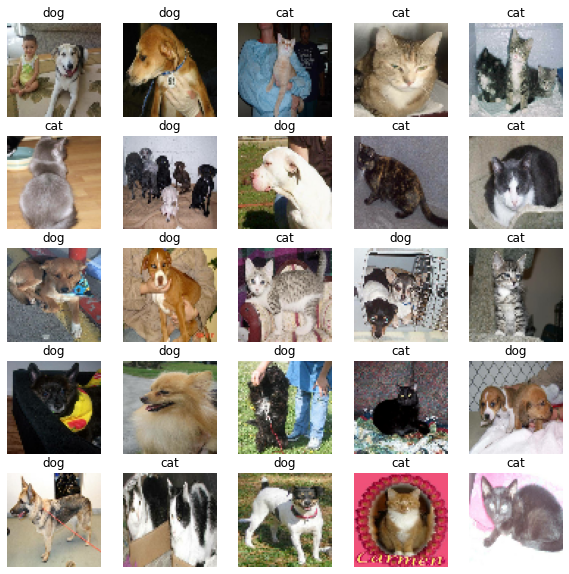

In [25]:
show_batch(image_batch.numpy(), label_batch.numpy(),CLASS_NAMES)

### Define Selectivenet

In [118]:
class CatsvsDogVgg:
    def __init__(self, input_dim, train_ds, val_ds=None, filename="weightsvgg.h5", coverage=0.8, alpha=0.5,train=True,
                 baseline=False):
        self.lamda = coverage
        self.alpha = alpha
        self.mc_dropout_rate = K.variable(value=0)
        self.num_classes = 2
        self.weight_decay = 0.0005

        self.x_shape = input_dim
        self.filename = filename

        self.model = self.build_model()
        if baseline:
            self.alpha = 0
              
        if(train & os.path.isfile("saved_data/{}".format(self.filename))):
            self.model.load_weights("saved_data/{}".format(self.filename))

    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.
        weight_decay = self.weight_decay
        basic_dropout_rate = 0.3
        input = Input(shape=self.x_shape)
        curr = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(input)
        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate)(curr)

        curr = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)
        curr = Dropout(basic_dropout_rate + 0.2)(curr)

        curr = Flatten()(curr)
        curr = Dense(512, kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.2)(curr)
        curr = Lambda(lambda x: K.dropout(x, level=self.mc_dropout_rate))(curr)

        # classification head (f)
        curr1 = Dense(self.num_classes, activation='softmax')(curr)

        # selection head (g)
        curr2 = Dense(512, kernel_regularizer=regularizers.l2(weight_decay))(curr)
        curr2 = Activation('relu')(curr2)
        curr2 = BatchNormalization()(curr2)
        # this normalization is identical to initialization of batchnorm gamma to 1/10
        curr2 = Lambda(lambda x: x / 10)(curr2)
        curr2 = Dense(1, activation='sigmoid')(curr2)
        # auxiliary head (h)
        selective_output = Concatenate(axis=1, name="selective_head")([curr1, curr2])

        auxiliary_output = Dense(self.num_classes, activation='softmax', name="classification_head")(curr)

        model = Model(inputs=input, outputs=[selective_output, auxiliary_output])

        self.input = input
#         self.model_embeding = Model(inputs=input, outputs=curr)
        return model


    def predict(self,x):
        return self.model.predict(x)

#     def predict_embedding(self, x=None, batch_size=128):
#         if x is None:
#             x = self.x_test
#         return self.model_embeding.predict(x, batch_size)

    def mc_dropout(self, batch_size=1000, dropout=0.5, iter=100):
        K.set_value(self.mc_dropout_rate, dropout)
        repititions = []
        for i in range(iter):
            _, pred = self.model.predict(self.x_test, batch_size)
            repititions.append(pred)
        K.set_value(self.mc_dropout_rate, 0)

        repititions = np.array(repititions)
        mc = np.var(repititions, 0)
        mc = np.mean(mc, -1)
        return -mc

    def selective_risk_at_coverage(self, coverage, mc=False):
        _, pred = self.predict()

        if mc:
            sr = np.max(pred, 1)
        else:
            sr = self.mc_dropout()
        sr_sorted = np.sort(sr)
        threshold = sr_sorted[pred.shape[0] - int(coverage * pred.shape[0])]
        covered_idx = sr > threshold
        selective_acc = np.mean(np.argmax(pred[covered_idx], 1) == np.argmax(self.y_test[covered_idx], 1))
        return selective_acc

    def train(self, model, train_ds,val_ds=None):
        c = self.lamda
        lamda = 32

        def selective_loss(y_true, y_pred):
            em_c =K.mean(y_pred[:, -1])
            loss = K.categorical_crossentropy(
                K.repeat_elements(y_pred[:, -1:], self.num_classes, axis=1) * y_true[:, :],
                y_pred[:, :-1]) + lamda * K.maximum(-em_c + c, 0) ** 2 
            return loss

        def selective_acc(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], 0.5), K.floatx())
            temp1 = K.sum(
                (g) * K.cast(K.equal(K.argmax(y_true[:, :-1], axis=-1), K.argmax(y_pred[:, :-1], axis=-1)), K.floatx()))
            temp1 = temp1 / K.sum(g)
            return K.cast(temp1, K.floatx())

        def coverage(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], 0.5), K.floatx())
            return K.mean(g)

        # training parameters
        batch_size = 128
        maxepoches = 300
        learning_rate = 0.1
        stepsperepoch=2000// batch_size

        lr_decay = 1e-6

        lr_drop = 25

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        early_stop_callback=tf.keras.callbacks.EarlyStopping(
            monitor='loss', min_delta=0.0001, patience=10, mode="min", restore_best_weights=True
        )
        # optimization details decay=lr_decay, , nesterov=True
        sgd = optimizers.SGD(lr=learning_rate, momentum=0.9)

        model.compile(loss=[selective_loss, 'categorical_crossentropy'], loss_weights=[self.alpha, 1 - self.alpha],
                      optimizer=sgd, metrics=['accuracy', selective_acc, coverage])

        historytemp = model.fit(train_ds, validation_data=val_ds, initial_epoch=41, epochs=maxepoches, shuffle=True, callbacks=[reduce_lr])

         
#         with open("checkpoints/{}_history.pkl".format(self.filename[:-3]), 'wb') as handle:
#             pickle.dump(historytemp.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

        model.save_weights("saved_data/{}".format(self.filename))
        self.model=model
        return historytemp

    def get_model(self):
        return self.model
    
    def set_model(self, model):
            self.model=model

In [21]:
c = 0.8
alpha = 0.5
weights ="weightsvgg3.h5"
lr_decay = 1e-6

In [119]:
catsdog_selectivenet = CatsvsDogVgg(IMG_SHAPE, train_ds=train_ds,
                                    filename=weights, coverage=c, alpha=alpha, train=True, baseline=False)

The following Variables were used a Lambda layer's call (lambda_6), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [127]:
history = catsdog_selectivenet.train(catsdog_selectivenet.get_model(),train_ds,val_ds=val_ds)

In [27]:
# catsdog_selectivenet.get_model().summary()

In [32]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle
import seaborn as sns

from selectivnet_utils import *
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
save_dir='saved_data'
history_header =",".join(["classification_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","classification_head_loss", "selective_head_loss", "classification_head_coverage", 
                  "selective_head_coverage","val_classification_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_classification_head_loss", "val_selective_head_loss",
                  "val_classification_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/catdog_vgg_history3.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [123]:
a=np.array([
    history.history['classification_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['classification_head_loss'],
    history.history['selective_head_loss'],
    history.history['classification_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_classification_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_classification_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_classification_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [124]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

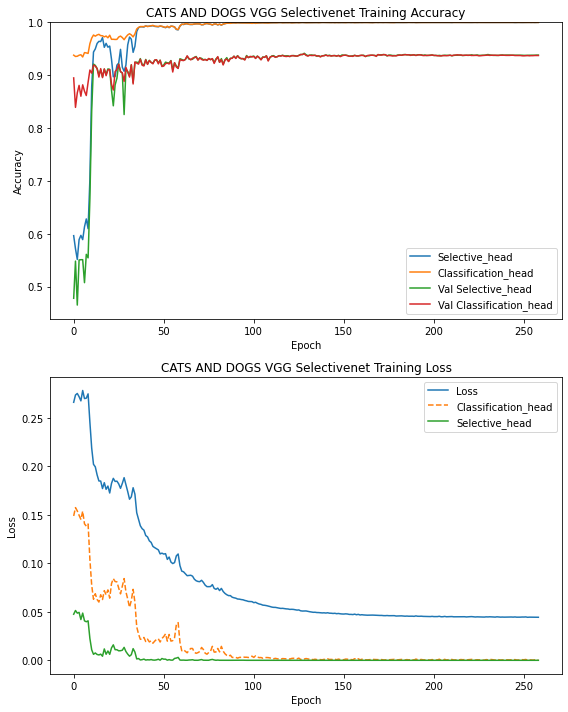

In [125]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['classification_head_accuracy'],linestyle='-', label='Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_classification_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CATS AND DOGS VGG Selectivenet Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['classification_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
# plt.plot(x,lr_curve['val_classification_head_loss'], linestyle='--', label='Val Classification_head')
# plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
# plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CATS AND DOGS VGG Selectivenet Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

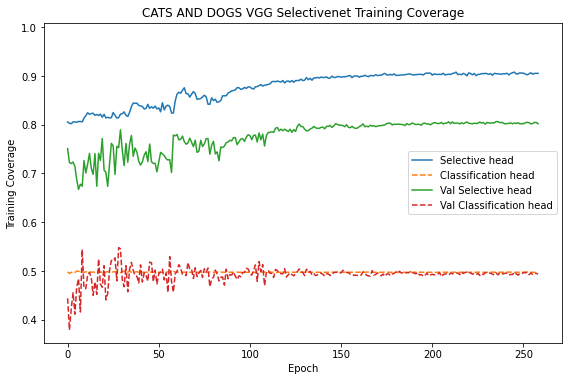

In [126]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['classification_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('CATS AND DOGS VGG Selectivenet Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [41]:
test_ds = tf.data.Dataset.from_tensor_slices((test_dir, test_labels.astype('float32')))
test_ds = test_ds.map(process_data, num_parallel_calls=AUTOTUNE)
test_ds=test_ds.batch(len(test_idx))
test_img,test_labels=next(iter(test_ds))

In [23]:
del dir_list
del labels
del val_dir
del val_labels
del train_dir
del train_labels

In [131]:
predictions= catsdog_selectivenet.predict(test_img) #set predictions for use

In [132]:
print("Shape of classification head predictions: ",predictions[0].shape)
y_true = np.argmax(test_labels,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Classification head predictions: ",y_pred.shape)      

Shape of classification head predictions:  (3750, 3)
Classification head predictions:  (3750,)


In [133]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Selective head Accuracy:",acc)
print("Classification head Accuracy:",aux_acc)

Selective head Accuracy: 0.9421333333333334
Classification head Accuracy: 0.9421333333333334


In [136]:
coverages = np.arange(0.5,1.05,0.05) # coverages
coverage_risk = np.zeros((coverages.shape[0],3), dtype = "float")
sel_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sel_coverages_risk[i]= selective_risk(c,test_labels,predictions[1],predictions[0][:,-1])
    i=i+1
    
i=0
for c in coverages:
    coverage_risk[i]= sr_selective_risk(c,test_labels,predictions[1],mc=True)
    i=i+1
sel_coverages_risk    

array([[0.5       , 0.00426667, 0.99573333],
       [0.54986667, 0.00436469, 0.99563531],
       [0.6       , 0.00488889, 0.99511111],
       [0.64986667, 0.00615511, 0.99384489],
       [0.7       , 0.008     , 0.992     ],
       [0.74986667, 0.01209104, 0.98790896],
       [0.8       , 0.016     , 0.984     ],
       [0.84986667, 0.02008158, 0.97991842],
       [0.9       , 0.02755556, 0.97244444],
       [0.94986667, 0.04183043, 0.95816957],
       [0.99973333, 0.0578821 , 0.9421179 ]])

In [139]:
coverage_risk

array([[0.49973333, 0.01173959, 0.98826041],
       [0.5496    , 0.01261524, 0.98738476],
       [0.5992    , 0.0129061 , 0.9870939 ],
       [0.6488    , 0.01315249, 0.98684751],
       [0.69893333, 0.01297215, 0.98702785],
       [0.7496    , 0.01245109, 0.98754891],
       [0.79973333, 0.01567189, 0.98432811],
       [0.8496    , 0.02008788, 0.97991212],
       [0.89973333, 0.02904564, 0.97095436],
       [0.9496    , 0.04184218, 0.95815782],
       [0.99973333, 0.0578821 , 0.9421179 ]])

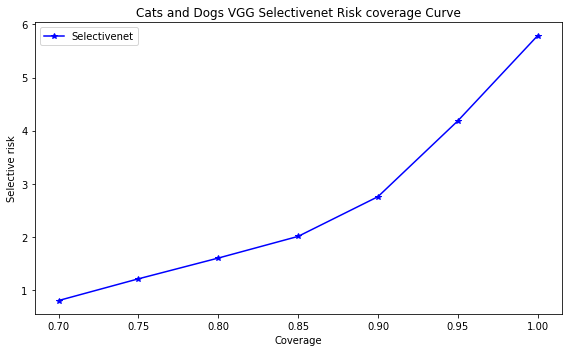

In [142]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],sel_coverages_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages[4:],coverage_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Selectivenet Risk coverage Curve')
plt.tight_layout()
plt.show()

### Baseline Model

In [143]:
baseline = "catsdogs_baseline_vgg3.h5"

In [146]:
catsdog_selectivenet = CatsvsDogVgg(IMG_SHAPE, train_ds=train_ds, val_ds=val_ds,
                                    filename=baseline, coverage=c, alpha=alpha, train=False, baseline=True)

The following Variables were used a Lambda layer's call (lambda_10), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [170]:
history = catsdog_selectivenet.train(catsdog_selectivenet.get_model(),train_ds=train_ds, val_ds=val_ds)

In [148]:
history_header =",".join(["classification_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","classification_head_loss", "selective_head_loss", "classification_head_coverage", 
                  "selective_head_coverage","val_classification_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_classification_head_loss", "val_selective_head_loss",
                  "val_classification_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/basemodel_catdog_vgg_history3.csv'
f=open(history_fname,"w")
f.write(history_header)
f.close()

In [149]:
a=np.array([
    history.history['classification_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['classification_head_loss'],
    history.history['selective_head_loss'],
    history.history['classification_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_classification_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_classification_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_classification_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

In [150]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

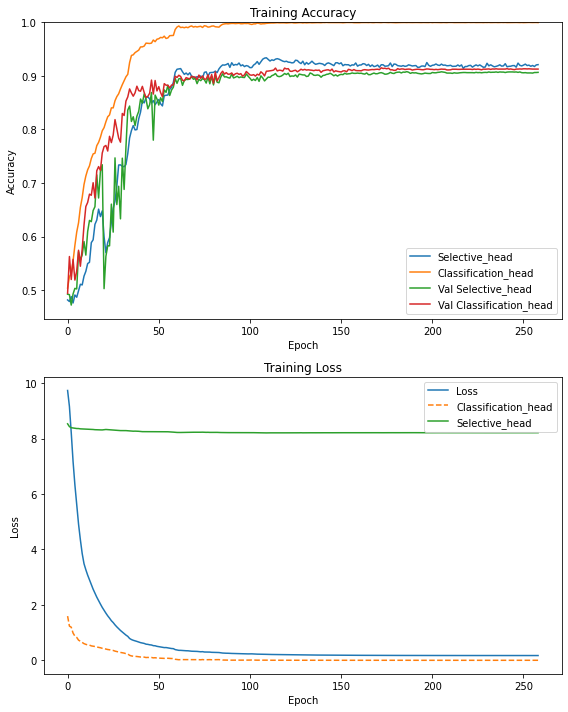

In [151]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['classification_head_accuracy'],linestyle='-', label='Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_classification_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['classification_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
# plt.plot(x,lr_curve['val_classification_head_loss'], linestyle='--', label='Val Classification_head')
# plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
# plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

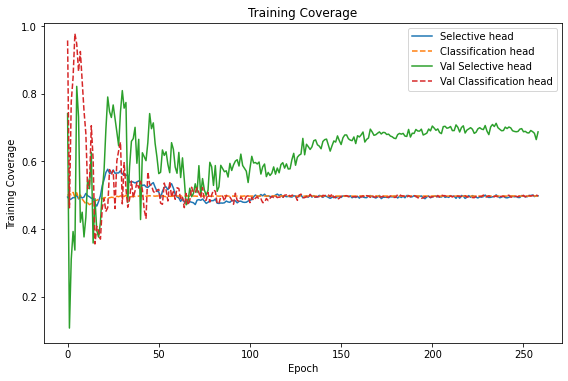

In [152]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['classification_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Training Coverage')
plt.tight_layout()
plt.show()

In [159]:
predictions= catsdog_selectivenet.predict(test_img) #set predictions for use

In [161]:
y_true = np.argmax(test_labels,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("BR predictions: ",y_pred.shape)      

BR predictions:  (3750,)


In [171]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
print("Selective head Accuracy:",acc)
acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Classification head Accuracy:",acc)

Selective head Accuracy: 0.9064
Classification head Accuracy: 0.9144


In [164]:
coverages = np.arange(0.5,1.05,0.05) # coverages
br_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    br_coverages_risk[i]= selective_risk(c,test_labels,predictions[1],predictions[0][:,-1])
    i=i+1
# br_coverages_risk    

In [166]:
coverages = np.arange(0.5,1.05,0.05) # coverages
br_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    br_sr_coverages_risk[i]= sr_selective_risk(c,test_labels,predictions[1],mc=True)
    i=i+1
br_sr_coverages_risk    

array([[0.49946667, 0.02028831, 0.97971169],
       [0.5496    , 0.01989326, 0.98010674],
       [0.59973333, 0.02134282, 0.97865718],
       [0.6496    , 0.02175698, 0.97824302],
       [0.69893333, 0.02556276, 0.97443724],
       [0.7496    , 0.03023835, 0.96976165],
       [0.79973333, 0.03434478, 0.96565522],
       [0.8496    , 0.04111739, 0.95888261],
       [0.89973333, 0.05542383, 0.94457617],
       [0.9496    , 0.07048582, 0.92951418],
       [0.99973333, 0.08562283, 0.91437717]])

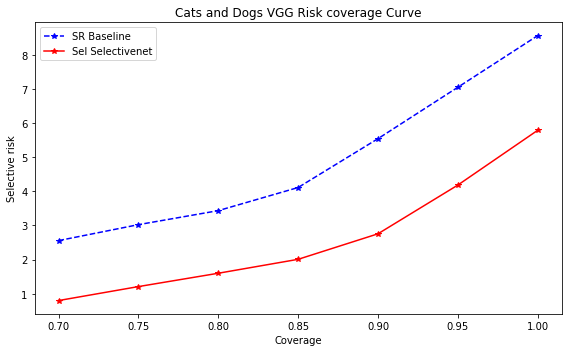

In [168]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,br_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],br_sr_coverages_risk[4:,1]*100,color='blue', linestyle='--',marker='*',label='SR Baseline')
ax.plot(coverages[4:],sel_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

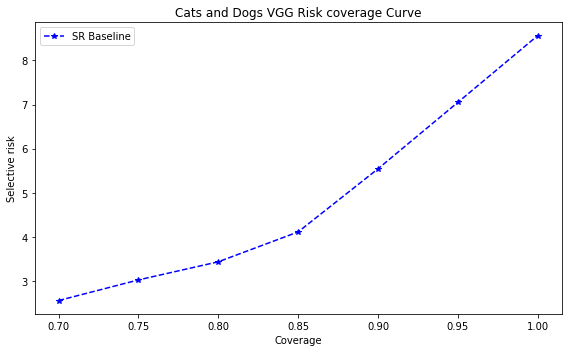

In [169]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,br_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],br_sr_coverages_risk[4:,1]*100,color='blue', linestyle='--',marker='*',label='SR Baseline')
# ax.plot(coverages[4:],sel_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

### SR model

In [154]:
from vgg_SR import vgg_SR_build_model

In [181]:
sr_model=vgg_SR_build_model(input_dim=IMG_SHAPE, num_classes=len(CLASS_NAMES),weight_decay=0.0005,mc_dropout_rate=0.1)

In [156]:
# sr_model.summary()

In [24]:
batch_size = 128
maxepoches = 300
stepsperepoch=2000// batch_size
learning_rate = 0.1
lr_drop = 25
def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [184]:
historytemp = sr_model.fit(train_ds, initial_epoch=0,
                          epochs=maxepoches, validation_data=val_ds, callbacks=[reduce_lr])

In [173]:
header =",".join(["accuracy", "loss","val_accuracy","val_loss\n"])
sr_history=save_dir+'/catsdogs_vgg_sr_history3.csv'
f=open(sr_history,"w")
f.write(header)
f.close()

In [174]:
sr_model.save_weights("saved_data/{}".format('catsdogs_vgg_SR3.h5'))

In [185]:
sr_model.load_weights("saved_data/{}".format('catsdogs_vgg_SR3.h5'))

In [175]:
a=np.array([
    historytemp.history['accuracy'],
    historytemp.history['loss'],
    historytemp.history['val_accuracy'],
    historytemp.history['val_loss']
]).T
write_csv(sr_history,a)

### SR learning curve

In [176]:
sr_curve=pd.read_csv(sr_history)
# sr_curve

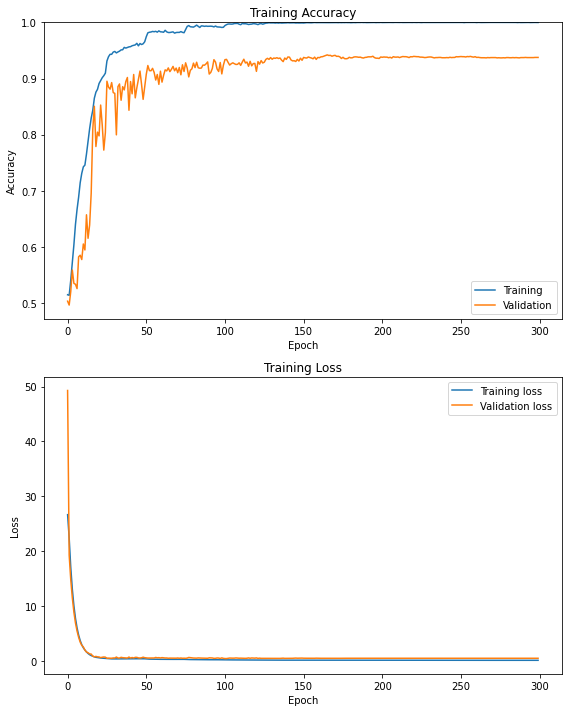

In [177]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(sr_curve.shape[0])
plt.plot(x,sr_curve['accuracy'],linestyle='-', label='Training')
plt.plot(x,sr_curve['val_accuracy'],linestyle='-', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x,sr_curve['loss'], label='Training loss')
plt.plot(x,sr_curve['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [186]:
predictions= sr_model.predict(test_img) #set predictions for use

In [187]:
y_true = np.argmax(test_labels,axis=1)
y_pred = np.argmax(predictions,axis=1)
print("SR predictions: ",y_pred.shape)      

SR predictions:  (3750,)


In [188]:
acc=my_evaluation(y_true,np.argmax(predictions,axis=1))
print("Accuracy:",acc)

Accuracy: 0.9437333333333333


In [190]:
sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sr_coverages_risk[i]= sr_selective_risk(c,test_labels,predictions,mc=True)
    i=i+1
sr_coverages_risk    

array([[0.49893333, 0.01068947, 0.98931053],
       [0.5496    , 0.01213003, 0.98786997],
       [0.59946667, 0.01245552, 0.98754448],
       [0.64933333, 0.01314168, 0.98685832],
       [0.69893333, 0.01259061, 0.98740939],
       [0.74933333, 0.01245552, 0.98754448],
       [0.79973333, 0.015005  , 0.984995  ],
       [0.8496    , 0.01851852, 0.98148148],
       [0.89973333, 0.02519265, 0.97480735],
       [0.9496    , 0.03538332, 0.96461668],
       [0.99973333, 0.05601494, 0.94398506]])

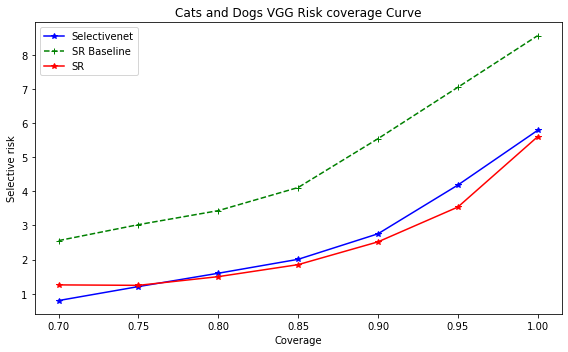

In [192]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],sel_coverages_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,br_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],br_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],sr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

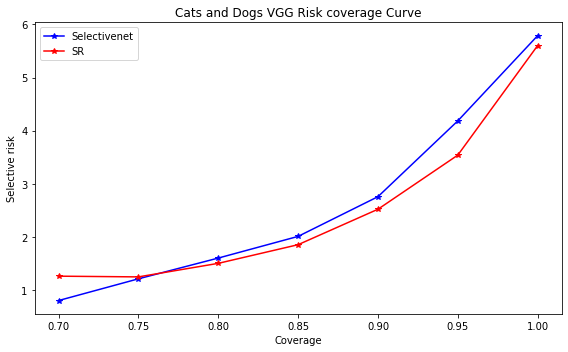

In [193]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],sel_coverages_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,br_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages[4:],br_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],sr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

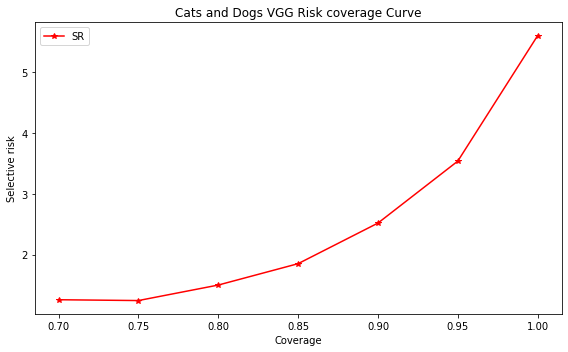

In [194]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages[4:],sel_coverages_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,br_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages[4:],br_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],sr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

In [25]:
from effnet_selectivenet import *

In [26]:
dropout = 0.2
mc_dropout =0.1
training=True
pooling="avg"
input_dims=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)
learning_rate = 0.025
momentum=0.9
initial_epoch=0
maxepoches=100

lr_decay = 1e-6
num_class = len(CLASS_NAMES)
def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [43]:
early_stop_callback=tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.0001, patience=10, restore_best_weights=True
)

In [37]:
my_selectivenet = SelectiveNet(dropout=dropout, mc_dropout = mc_dropout, num_classes=num_class,
                               training=training, input_dim=input_dims,pooling=pooling)
my_selectivenet.compile_model(c=c,lr=learning_rate,decay=lr_decay,alpha=0.5)

In [55]:
# my_selectivenet.get_model().summary()

In [47]:
history = my_selectivenet.model_train(train_ds=train_ds, val_ds=val_ds, EPOCHS=maxepoches, initial_epoch=initial_epoch, shuffle=True, 
                                      verbose=1, callbacks = [reduce_lr])

In [39]:
save_dir='saved_data'
history_header =",".join(["auxilary_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","auxilary_head_loss", "selective_head_loss", "auxilary_head_coverage", 
                  "selective_head_coverage","val_auxilary_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_auxilary_head_loss", "val_selective_head_loss",
                  "val_auxilary_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/catsdogs_effnet_history3.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [40]:
a=np.array([
    history.history['auxilary_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['auxilary_head_loss'],
    history.history['selective_head_loss'],
    history.history['auxilary_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_auxilary_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_auxilary_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_auxilary_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [48]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

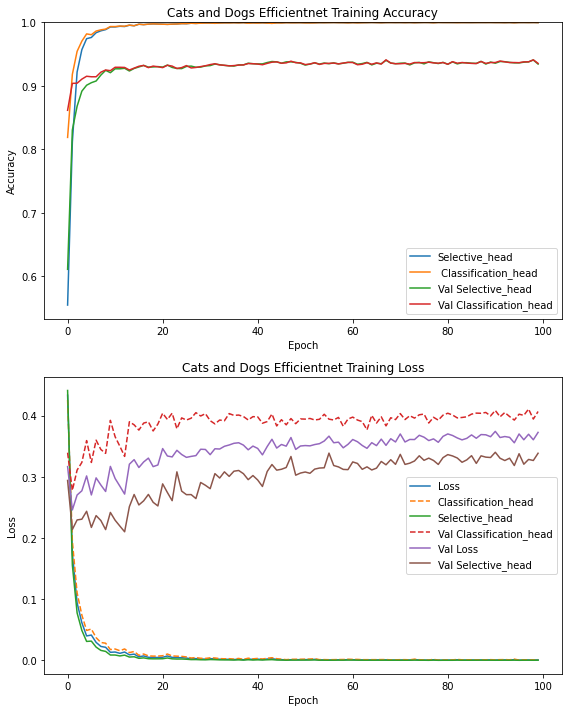

In [49]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['auxilary_head_accuracy'],linestyle='-', label=' Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Cats and Dogs Efficientnet Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['auxilary_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_loss'], linestyle='--', label='Val Classification_head')
plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Cats and Dogs Efficientnet Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

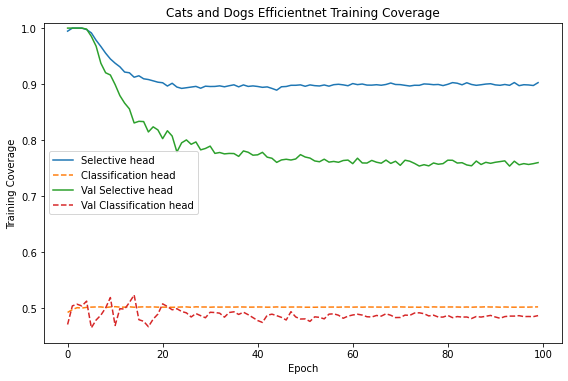

In [50]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['auxilary_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_auxilary_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Cats and Dogs Efficientnet Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [41]:
# my_selectivenet.get_model().save_weights(save_dir+'/effnet_sel_model2.h5')

In [57]:
my_selectivenet.set_model_weights(save_dir+'/effnet_sel_model2.h5')

In [58]:
predictions = my_selectivenet.classification_predict(test_img) #set predictions for use    

In [59]:
print("Shape of selective head predictions: ",predictions[0].shape)
y_true = np.argmax(test_labels,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Selective head predictions: ",y_pred.shape)      

Shape of selective head predictions:  (3750, 3)
Selective head predictions:  (3750,)


In [60]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Accuracy:",acc)
print("Classification Accuracy:",aux_acc)

Accuracy: 0.9778666666666667
Classification Accuracy: 0.9773333333333334


In [61]:
coverages = np.arange(0.5,1.05,0.05) # coverages
esel_coverage_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esel_coverage_risk[i] = selective_risk(c,test_labels,predictions[1],predictions[0][:,-1]) #coverage_risk[0]
    i=i+1

esel_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esel_sr_coverages_risk[i]= sr_selective_risk(c,test_labels,predictions[1],mc=True)
    i=i+1
esel_coverage_risk    

/home/evelynanyebe/skin_cancer/catsdogs_selnet/selectivnet_utils.py:63: RuntimeWarning: invalid value encountered in long_scalars
  np.argmax(y_true[covered_idx], 1)))/np.sum(covered_idx)


array([[5.00000000e-01, 5.33333333e-04, 9.99466667e-01],
       [5.49866667e-01, 1.45489816e-03, 9.98545102e-01],
       [6.00000000e-01, 1.77777778e-03, 9.98222222e-01],
       [6.49866667e-01, 1.64136233e-03, 9.98358638e-01],
       [7.00000000e-01, 1.90476190e-03, 9.98095238e-01],
       [7.49866667e-01, 1.77809388e-03, 9.98221906e-01],
       [8.00000000e-01, 1.66666667e-03, 9.98333333e-01],
       [8.49866667e-01, 2.82397239e-03, 9.97176028e-01],
       [9.00000000e-01, 4.74074074e-03, 9.95259259e-01],
       [9.49866667e-01, 8.14149354e-03, 9.91858506e-01],
       [9.99733333e-01, 2.26727127e-02, 9.77327287e-01]])

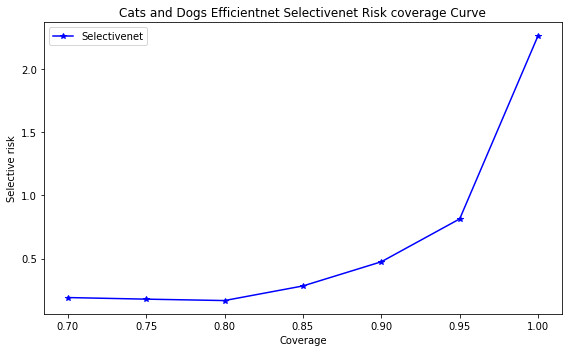

In [62]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],esel_coverage_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages[4:],esel_sr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='Classification head')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs Efficientnet Selectivenet Risk coverage Curve')
plt.tight_layout()
plt.show()

In [27]:
my_selectivenet = SelectiveNet(dropout=dropout, mc_dropout = mc_dropout, num_classes=num_class,
                               training=training, input_dim=input_dims,pooling=pooling)
my_selectivenet.compile_model(c=c,lr=learning_rate,decay=lr_decay,alpha=0.0)

In [40]:
history = my_selectivenet.model_train(train_ds=train_ds, val_ds=val_ds, EPOCHS=maxepoches, initial_epoch=initial_epoch, shuffle=True, 
                                      verbose=1, callbacks = [reduce_lr])

In [33]:
history_header =",".join(["auxilary_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","auxilary_head_loss", "selective_head_loss", "auxilary_head_coverage", 
                  "selective_head_coverage","val_auxilary_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_auxilary_head_loss", "val_selective_head_loss",
                  "val_auxilary_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/catsdogs_basemodel_effnet_history3.csv'
f=open(history_fname,"w")
f.write(history_header)
f.close()

In [34]:
a=np.array([
    history.history['auxilary_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['auxilary_head_loss'],
    history.history['selective_head_loss'],
    history.history['auxilary_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_auxilary_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_auxilary_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_auxilary_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [35]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

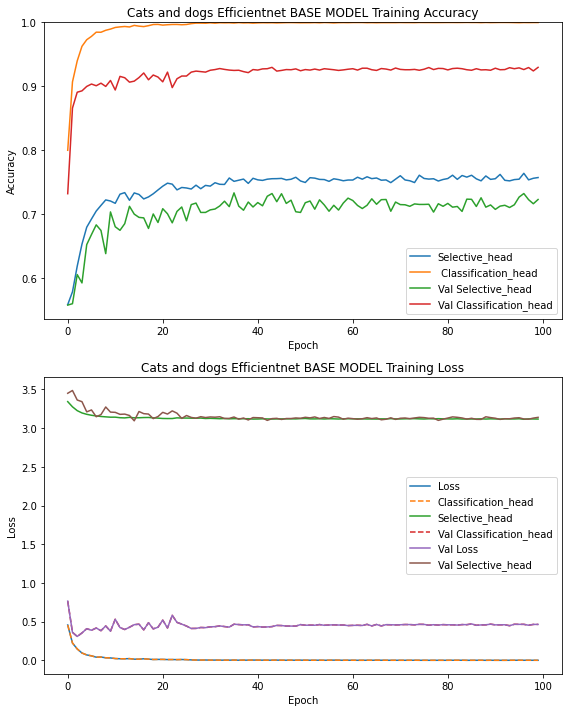

In [36]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['auxilary_head_accuracy'],linestyle='-', label=' Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Cats and dogs Efficientnet BASE MODEL Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['auxilary_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_loss'], linestyle='--', label='Val Classification_head')
plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Cats and dogs Efficientnet BASE MODEL Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

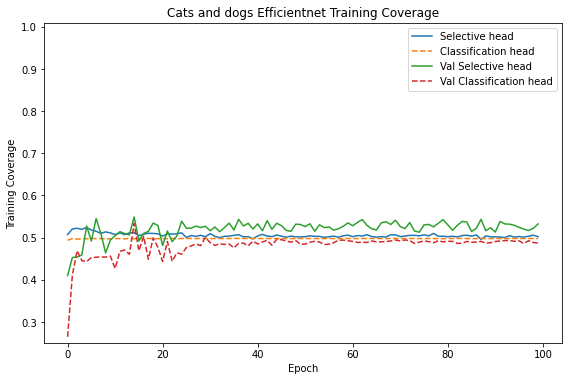

In [37]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['auxilary_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_auxilary_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Cats and dogs Efficientnet Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [38]:
my_selectivenet.get_model().save_weights(save_dir+'/effnet_base_model3.h5')

In [237]:
# my_selectivenet.set_model_weights(save_dir+'/effnet_base_model.h5')

In [52]:
predictions = my_selectivenet.classification_predict(test_img) #set predictions for use    

In [53]:
print("Shape of selective head predictions: ",predictions[0].shape)
y_true = np.argmax(test_labels,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Selective head predictions: ",y_pred.shape)      

Shape of selective head predictions:  (3750, 3)
Selective head predictions:  (3750,)


In [54]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("BR Accuracy:",acc)
print("BR Classification Accuracy:",aux_acc)

BR Accuracy: 0.7250666666666666
BR Classification Accuracy: 0.9309333333333333


In [55]:
coverages = np.arange(0.5,1.05,0.05) # coverages
ebr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    ebr_coverages_risk[i]= selective_risk(c,test_labels,predictions[1],predictions[0][:,-1])
    i=i+1

ebr_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    ebr_sr_coverages_risk[i]= sr_selective_risk(c,test_labels,predictions[1],mc=True)
    i=i+1
ebr_sr_coverages_risk    

array([[0.        ,        nan,        nan],
       [0.        ,        nan,        nan],
       [0.        ,        nan,        nan],
       [0.6384    , 0.01002506, 0.98997494],
       [0.6984    , 0.01298205, 0.98701795],
       [0.74906667, 0.01708793, 0.98291207],
       [0.79946667, 0.02168112, 0.97831888],
       [0.8496    , 0.02856246, 0.97143754],
       [0.89973333, 0.03852993, 0.96147007],
       [0.9496    , 0.04942432, 0.95057568],
       [0.99973333, 0.06881835, 0.93118165]])

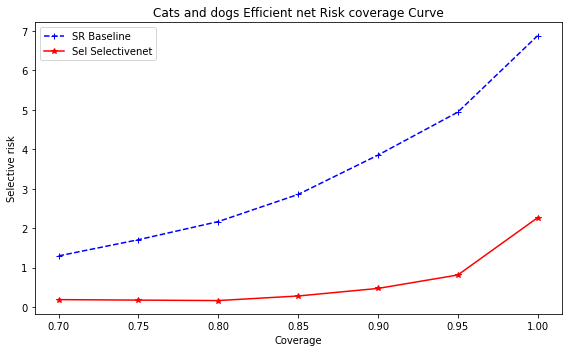

In [63]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages[4:],ebr_coverages_risk[4:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],ebr_sr_coverages_risk[4:,1]*100,color='blue', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],esel_coverage_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages[4:],esel_sr_coverages_risk[4:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

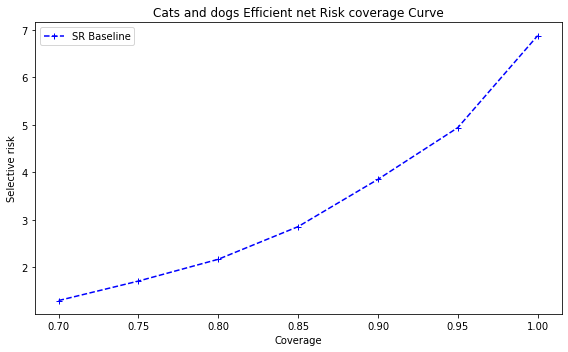

In [64]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages[4:],ebr_coverages_risk[4:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],ebr_sr_coverages_risk[4:,1]*100,color='blue', linestyle='--',marker='+',label='SR Baseline')
# ax.plot(coverages[4:],esel_coverage_risk[:,1]*100,color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages[4:],esel_sr_coverages_risk[4:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

### SR model

In [65]:
from effnet_SR import SR_model

In [66]:
sr_model=SR_model(num_classes=len(CLASS_NAMES),dropout=dropout,mc_dropout=mc_dropout,input_dim=IMG_SHAPE,training=True)

In [67]:
# sr_model.summary()

In [68]:
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=momentum, nesterov=True)
sr_model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [73]:
historytemp = sr_model.fit(train_ds, 
                          epochs=maxepoches,validation_data=val_ds,callbacks=[reduce_lr])

In [70]:
sr_model.save_weights("saved_data/{}".format('catsdogs_effnet_SR3.h5'))

In [71]:
header =",".join(["accuracy","loss","val_accuracy", "val_loss\n"])
sr_history=save_dir+'/catsdogs_effnet_sr_history3.csv'
f=open(sr_history,"w")
f.write(header)
f.close()

In [72]:
a=np.array([
    historytemp.history['accuracy'],
    historytemp.history['loss'],
    historytemp.history['val_accuracy'],
    historytemp.history['val_loss']
]).T
write_csv(sr_history,a)

### SR learning curve

In [74]:
sr_curve=pd.read_csv(sr_history)

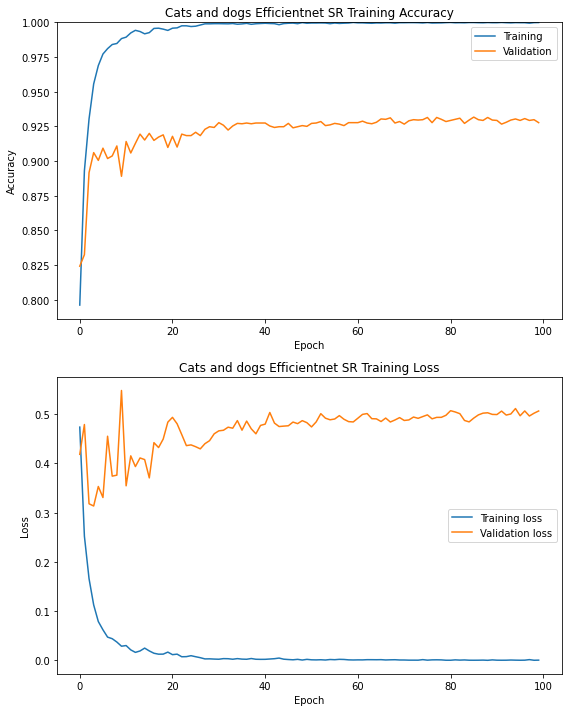

In [75]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(sr_curve.shape[0])
plt.plot(x,sr_curve['accuracy'],linestyle='-', label='Training')
plt.plot(x,sr_curve['val_accuracy'],linestyle='-', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Cats and dogs Efficientnet SR Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x,sr_curve['loss'], label='Training loss')
plt.plot(x,sr_curve['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Cats and dogs Efficientnet SR Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [76]:
predictions= sr_model.predict(test_img) #set predictions for use

In [77]:
y_true = np.argmax(test_labels,axis=1)
y_pred = np.argmax(predictions,axis=1)
print("SR predictions: ",y_pred.shape)      

SR predictions:  (3750,)


In [78]:
acc=my_evaluation(y_true,np.argmax(predictions,axis=1))
print("Accuracy:",acc)

Accuracy: 0.9336


In [83]:
esr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esr_coverages_risk[i]= sr_selective_risk(c,test_labels,predictions,mc=True)
    i=i+1
esr_coverages_risk    

/home/evelynanyebe/skin_cancer/catsdogs_selnet/selectivnet_utils.py:63: RuntimeWarning: invalid value encountered in long_scalars
  np.argmax(y_true[covered_idx], 1)))/np.sum(covered_idx)


array([[0.        ,        nan,        nan],
       [0.        ,        nan,        nan],
       [0.57573333, 0.00555813, 0.99444187],
       [0.648     , 0.00740741, 0.99259259],
       [0.69946667, 0.0106748 , 0.9893252 ],
       [0.7496    , 0.01280683, 0.98719317],
       [0.79973333, 0.02167389, 0.97832611],
       [0.8496    , 0.02667922, 0.97332078],
       [0.89973333, 0.03497333, 0.96502667],
       [0.9496    , 0.04942432, 0.95057568],
       [0.99973333, 0.06615097, 0.93384903]])

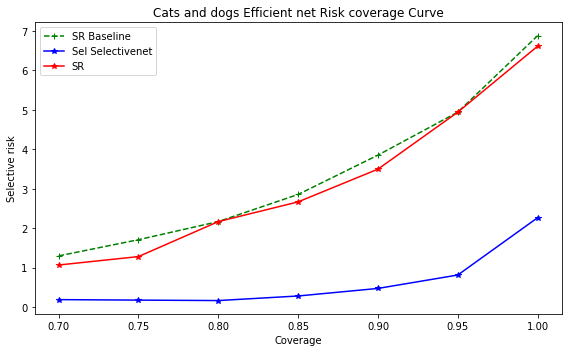

In [80]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages[4:],ebr_coverages_risk[4:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],ebr_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],esel_coverage_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Sel Selectivenet')
ax.plot(coverages[4:],esr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

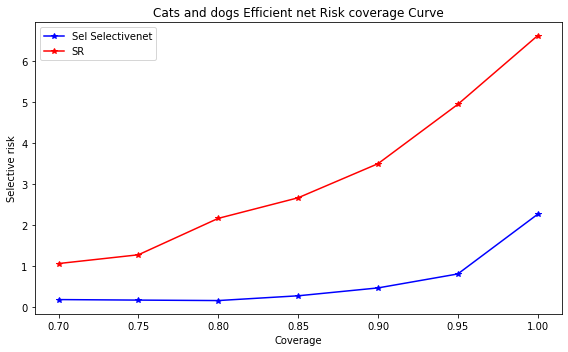

In [81]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages[4:],ebr_coverages_risk[4:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages[4:],ebr_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],esel_coverage_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Sel Selectivenet')
ax.plot(coverages[4:],esr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

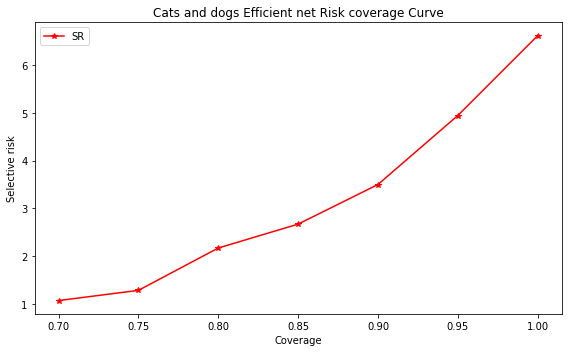

In [82]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages[4:],ebr_coverages_risk[4:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages[4:],ebr_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
# ax.plot(coverages[4:],esel_coverage_risk[:,1]*100,color='blue', linestyle='-',marker='*',label='Sel Selectivenet')
ax.plot(coverages[4:],esr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()